<a href="https://colab.research.google.com/github/amrits-hub/Data_Science_Portfolio/blob/main/Alzheimer's_Classifier_DNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<h1 align="center"></h1>

<h2 align="center">Computer Vision: Diagnosing Dementia</h2>

<h2 align="center">Amrit Sandhir</h2>


#### Alzheimer's is a degenerative disease that causes the brain to shrink and brain cells to eventually die. It is the most common cause of dementia characterized by memory loss, decline in behavior and social skills. It is an especially heartbreaking condition not only for the individuals suffering from the disease, but also their family members and friends. There is no cure for it currently.

#### According to the Mayo Clinic, approximately 6.5 million people in the United States 65 years and older have Alzheimer's disease. More than 70% diagnosed are 75 years and older, and of the about 55 million people worldwide with dementia, 60% to 70% are estimated to have Alzheimer's disease. Diagnosis is typically performed through lab (blood work) and cognitive tests, and brain imaging scans. The latter can help detect changes in the brain caused by the disease, identify its progression and severity, and be compared to brain scans of baseline scans of individuals without it.

#### This analysis will utilize a dataset of brain scan images with their target outcomes (diagnoses) to train a deep Convulational Neural Network (CNN) model to detect and identify spatial patterns in images associated with the diagnosis, ranging from 'Non-Demented' to 'Moderate Demented.' Once the CNN model has been trained, the model will predict the target class (diagnosis) on an unseen test dataset. The predicted class will be compared to the actual class/diagnosis and evaluated on certain metrics such as accuracy, precision, and others.

In [ ]:
pip install datasets

In [ ]:
pip install torchmetrics

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from IPython.core.display import HTML

In [ ]:
# HuggingFace MRI train split dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

In [ ]:
dataset.shape

(5120, 2)

In [ ]:
print(type(dataset['image'][0]))
print(type(dataset['label'][0]))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'int'>


In [ ]:
from itertools import islice

for i in islice(dataset, 0, 3):
    print(i)

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7A0B28A1CD30>, 'label': 2}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7A0B28A1CC40>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=128x128 at 0x7A0B28A1CCA0>, 'label': 3}


In [ ]:
#training set
images = []
labels = []

for i in dataset:
    images += [np.array(i["image"])]
    labels += [i["label"]]

images = np.array(images)
labels = np.array(labels)

In [ ]:
print(type(images))
print(type(images[0]))

print(type(labels))
print(type(labels[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
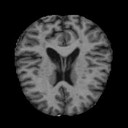

In [ ]:
images[0]

In [ ]:
labels[0]

2

In [ ]:
train_df=pd.DataFrame(data={'image': dataset['image'], 'label': dataset['label']})

label_map={0: 'Mild_Demented', 1: 'Moderate_Demented', 2: 'Non_Demented', 3: 'Very_Mild_Demented'}

train_df['diagnosis']=train_df.label.map(label_map)

train_df.head()

,image,label,diagnosis
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,Non_Demented
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,Mild_Demented
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,Very_Mild_Demented
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,Very_Mild_Demented
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,Non_Demented


In [ ]:
HTML(round(train_df.diagnosis.value_counts(),3).to_frame(name='diagnosis').sort_index().T.to_html())

diagnosis,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented
diagnosis,724,49,2566,1781


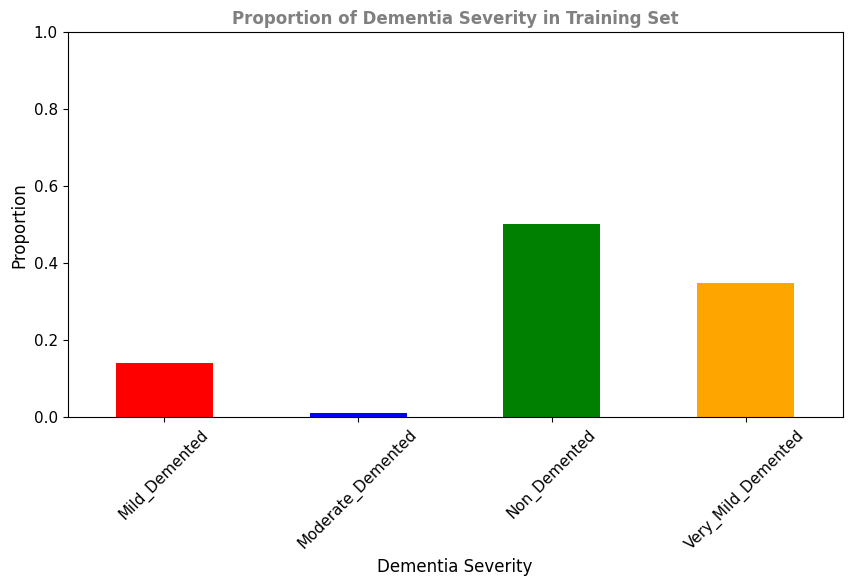

In [ ]:
(round(train_df.diagnosis.value_counts(normalize=True),3).
       sort_index().plot(kind='bar',
        color=['red', 'blue', 'green', 'orange'],
        fontsize=11,
        figsize=(10,5))
)
plt.title(fontsize=12, fontweight='bold', label='Proportion of Dementia Severity in Training Set', color='grey')
plt.xticks(rotation=45)
plt.xlabel('Dementia Severity', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.ylim(0,1)
plt.show()

##### As the above statistics and graph indicate, the 'Moderate Demented' class has a low number/proportion of images represented in the training dataset. This is unsurprising since it represents the highest scale/severity of a diagnosis.  In order for the model to become better trained at identifying these cases, this class (1) will be upsampled.

In [ ]:
# Upsampl the 'Moderate_Demented' class (1)

data=round(train_df.label.value_counts(normalize=True),3).to_frame(name='label').sort_index()

weights=np.array([data.iloc[0,0], data.iloc[2,0], data.iloc[3,0]])
print('\033[1m','Weights:', weights, '\n')

data_smples=train_df.label.value_counts().to_frame(name='label').sort_index()
smples=np.array([data_smples.iloc[0,0], data_smples.iloc[2,0], data_smples.iloc[3,0]])
print('\033[1m', 'Samples:', smples, '\n')

n_samples=int(np.mean(weights*smples))
print('\033[1m', 'Upsampled', n_samples, '\n')

mod_dmntd_upsmpld=resample(train_df.loc[train_df.diagnosis=='Moderate_Demented',:].values, replace=True
                          ,n_samples=n_samples
                          )

 Weights: [0.141 0.501 0.348] 

 Samples: [ 724 2566 1781] 

 Upsampled 669 



In [ ]:
#combine upsampled data with original train dataset
mod_dmntd_upsmpld_df=pd.DataFrame(data=mod_dmntd_upsmpld, columns=train_df.columns)

train_df=pd.concat([train_df, mod_dmntd_upsmpld_df], axis=0).reset_index(drop=True)
train_df.shape


(5789, 3)

In [ ]:
HTML(round(train_df.label.value_counts(),3).to_frame(name='diagnosis').sort_index().T.to_html())


label,0,1,2,3
diagnosis,724,718,2566,1781


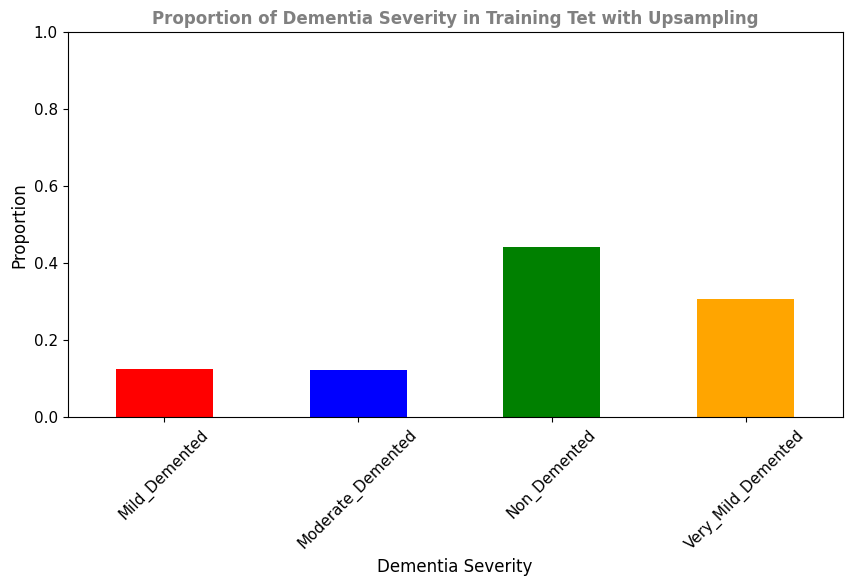

In [ ]:
(round(train_df.diagnosis.value_counts(normalize=True),3).
       sort_index().plot(kind='bar',
        color=['red', 'blue', 'green', 'orange'],
        fontsize=11,
        figsize=(10,5))
)
plt.title(fontsize=12, fontweight='bold', label='Proportion of Dementia Severity in Training Tet with Upsampling', color='grey')
plt.xticks(rotation=45)
plt.xlabel('Dementia Severity', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.ylim(0,1)
plt.show()

In [ ]:
df=pd.DataFrame()

for i in range(4):
    input=train_df.loc[train_df.label==i][:6]
    df=pd.concat([df,input], axis=0)

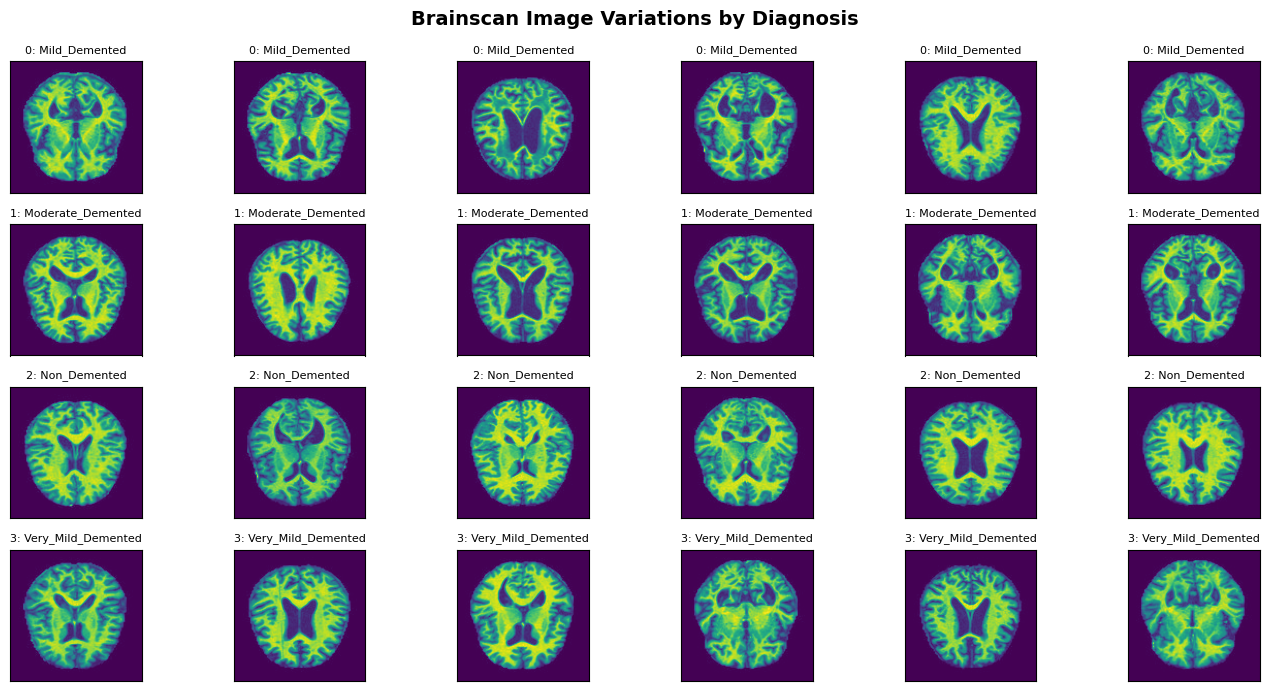

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=6, sharex=True, sharey=True, figsize=(15,7))
ax = ax.flatten()
plt.suptitle('Brainscan Image Variations by Diagnosis', fontsize=14, fontweight='bold')


for i in range(24):
    img=np.array(df.iloc[i,0])
    ax[i].imshow(img)

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(f'{df.iloc[i,1]}: {label_map[df.iloc[i,1]]}', size=8)
    plt.tight_layout()

plt.show()

##### As we can above, anyone without proper training or experience in diagnosing Alzheimer's would have a very hard time identifying severity.  Even within a target diagnosis (e.g, 'Mild Demented') there is much variation in images.  

In [ ]:
img=np.array(dataset[0]['image'])
print('\033[1m','Original: ', img.shape, type(img), '\n')

img2=img.reshape(img.shape[0], img.shape[1], 1)

print('\033[1m','Reshaped with Channel: ', img2.shape, type(img2), img2.dtype, '\n')

img_tensor = transforms.ToTensor()(img2)

print('\033[1m', 'Tensor with Channel as 1st Dimension: ', img_tensor.shape, type(img_tensor), img_tensor.dtype, img_tensor.min(), img_tensor.max(), '\n')

 Original:  (128, 128) <class 'numpy.ndarray'> 

 Reshaped with Channel:  (128, 128, 1) <class 'numpy.ndarray'> uint8 

 Tensor with Channel as 1st Dimension:  torch.Size([1, 128, 128]) <class 'torch.Tensor'> torch.float32 tensor(0.) tensor(0.6157) 



In [ ]:
transform = transforms.Compose([transforms.ToPILImage(), #convert Tensor of shape C x H x W or ndarray of shape H x W x C to a PIL Image

                                transforms.ToTensor(),   #convert a PIL Image (H x W x C) in the range [0, 255]
                                                         #to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
                                                         #if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
                                                         #or if the numpy.ndarray has dtype = np.uint8

                               #transforms.Normalize(mean=[0.5], std=[0.5]) #Normalize a tensor image with mean and standard deviation.
                               transforms.Normalize(mean=[0.0], std=[1.0]) #Normalize a tensor image with mean and standard deviation.

                               ])

In [ ]:
class PreProcess(Dataset):
    def __init__(self, images, labels, transform):
        super(PreProcess, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img, label = self.images[idx], self.labels[idx]
        img = self.transform(img.reshape(img.shape[0], img.shape[1], 1))


        return img, label

In [ ]:
# Attach Upsamples

dataset_images=train_df.image.to_list()
dataset_labels=train_df.label.to_list()

dataset_w_upsmpl={'image': dataset_images, 'label': dataset_labels}

type(dataset_w_upsmpl['image'][0])


PIL.JpegImagePlugin.JpegImageFile

In [ ]:
#training set
images_2 = []
labels_2 = []

for i in dataset_w_upsmpl['image']:
    images_2+=[np.array(i)]

for i in dataset_w_upsmpl['label']:
    labels_2+=[i]

images_2=np.array(images_2)
labels_2=np.array(labels_2)

print(type(images_2))
print(type(images_2[0]))

print(type(labels_2))
print(type(labels_2[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>


In [ ]:
#split training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images_2, labels_2,
                                                                      random_state=42, test_size=0.2)

In [ ]:
train_ds = PreProcess(train_images, train_labels, transform)
val_ds = PreProcess(val_images, val_labels, transform)

In [ ]:
# Set batch size to 10 instances and number of epochs to 10 for iterations of model training
BATCH_SIZE=10

NUM_EPOCHS=10

In [ ]:
dataset_train=DataLoader(train_ds, shuffle=True, batch_size=BATCH_SIZE)
dataset_val=DataLoader(val_ds, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
class DementiaModel(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.n_classes = n_classes
        conv1 = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.padding)
        elu1 = nn.ELU()
        pool1 = nn.AdaptiveMaxPool2d((64, 64))
        conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        elu2 = nn.ELU()
        pool2 = nn.AdaptiveMaxPool2d((32, 32))
        flatten = nn.Flatten()              # flatten output to 65536 parameters
        fc1 = nn.Linear(65536, 1024)
        relu3 = nn.ReLU()
        dropout = nn.Dropout(p=0.5)
        fc2 = nn.Linear(1024, n_classes)    # number of diagnosed classes for dementia
        self.sequential = nn.Sequential(conv1, elu1, pool1, conv2, elu2, pool2, flatten, fc1, relu3, dropout, fc2)

    def forward(self, x):
      return self.sequential(x)

In [ ]:
# Instantiate the model
model = DementiaModel(in_channels=1, out_channels=32, kernel_size=3, padding=1, n_classes=4)

# Batch size =10, channel in=1 (grey scale), height=128, width=128
x = torch.ones((BATCH_SIZE, 1, 128, 128))
model(x).shape

torch.Size([10, 4])

In [ ]:
# Instantiating multiclass loss function and ADAM optimizer

criterion=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# processing device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
print('\n'+'\033[94m')
print('\033[1m', 'MODEL ARCHITECTURE\n')
print('\n'+'\033[1m', model.eval())



 MODEL ARCHITECTURE


 DementiaModel(
  (sequential): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): AdaptiveMaxPool2d(output_size=(64, 64))
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): AdaptiveMaxPool2d(output_size=(32, 32))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=65536, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=1024, out_features=4, bias=True)
  )
)


In [ ]:
#training loop

from copy import deepcopy

def train(model, num_epochs, dataset_train, dataset_val):

    best_model = deepcopy(model)
    best_acc = 0

    # Initialize lists to store training and validation loss and accuracy
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    # Move the model to the device
    model.to(device)


    for epoch in range(num_epochs):
        model.train()                        #model in training mode
        for x_batch, y_batch in dataset_train:

            optimizer.zero_grad()             #reset the gradients to 0
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()                   #compute gradients
            optimizer.step()                  #update model parameters based on gradients

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(dataset_train.dataset)
        accuracy_hist_train[epoch] /= len(dataset_train.dataset)

        model.eval()                          #model in inference mode evaluate validation set
        with torch.no_grad():                 #gradient updates no longer needed
            for x_batch, y_batch in dataset_val:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = criterion(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()


        loss_hist_valid[epoch] /= len(dataset_val.dataset)
        accuracy_hist_valid[epoch] /= len(dataset_val.dataset)

        if accuracy_hist_valid[epoch] > best_acc:
          best_acc = accuracy_hist_valid[epoch]
          best_model = deepcopy(model)


        print('\033[94m', '\n'+'\033[1m'+f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f}'
              '\t'+'\033[91m', '\033[1m'+f'\tval_accuracy: {accuracy_hist_valid[epoch]:.4f}')


    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid, best_acc, best_model

In [ ]:
torch.manual_seed(1)

hist = train(model, NUM_EPOCHS, dataset_train, dataset_val)

 
Epoch 1 accuracy: 0.5321	 	val_accuracy: 0.6364
 
Epoch 2 accuracy: 0.6238	 	val_accuracy: 0.7124
 
Epoch 3 accuracy: 0.6748	 	val_accuracy: 0.7547
 
Epoch 4 accuracy: 0.7683	 	val_accuracy: 0.8437
 
Epoch 5 accuracy: 0.8687	 	val_accuracy: 0.8601
 
Epoch 6 accuracy: 0.9115	 	val_accuracy: 0.9223
 
Epoch 7 accuracy: 0.9382	 	val_accuracy: 0.9456
 
Epoch 8 accuracy: 0.9603	 	val_accuracy: 0.9551
 
Epoch 9 accuracy: 0.9570	 	val_accuracy: 0.9568
 
Epoch 10 accuracy: 0.9639	 	val_accuracy: 0.9594


In [ ]:
# Best validation accuracy score
round(hist[-2].item(),4)

0.9594

In [ ]:
for p in hist[-1].parameters():
  print('\033[1m', p.size(), '\n')

 torch.Size([32, 1, 3, 3]) 

 torch.Size([32]) 

 torch.Size([64, 32, 3, 3]) 

 torch.Size([64]) 

 torch.Size([1024, 65536]) 

 torch.Size([1024]) 

 torch.Size([4, 1024]) 

 torch.Size([4]) 



In [ ]:
best_model=hist[-1]

# Total number of trainable parameters
model_parameters = filter(lambda p: p.requires_grad, best_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('\033[1m',
      f'The model has {params:,} trainable parameters')

 The model has 67,132,804 trainable parameters


### Visualizations of Training and Validation Loss and Accuracy Scores Along Epochs

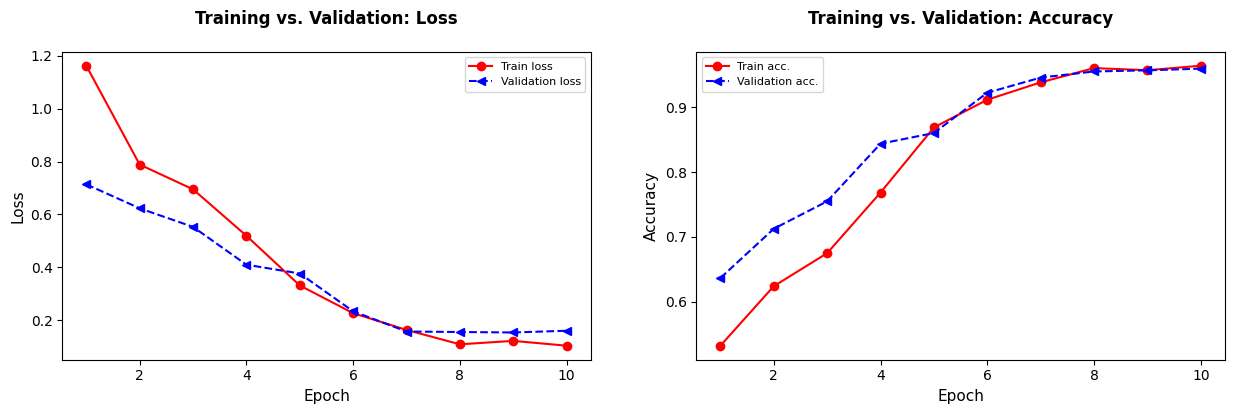

In [ ]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], 'r-o', label='Train loss')
ax.plot(x_arr, hist[1], 'b--<', label='Validation loss')
ax.set_xlabel('Epoch', size=11)
ax.set_ylabel('Loss', size=11)
ax.legend(fontsize=8, loc='best')
plt.title('Training vs. Validation: Loss', weight='bold', pad=20)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], 'r-o', label='Train acc.')
ax.plot(x_arr, hist[3], 'b--<', label='Validation acc.')
ax.legend(fontsize=8, loc='best')
ax.set_xlabel('Epoch', size=11)
ax.set_ylabel('Accuracy', size=11)
plt.title('Training vs. Validation: Accuracy', weight='bold', pad=20)
plt.show()

In [ ]:
dataset_test=load_dataset('Falah/Alzheimer_MRI', split='test')
dataset_test.shape

(1280, 2)

In [ ]:
test_images = []
test_labels = []

for i in dataset_test:
    test_images += [np.array(i["image"])]
    test_labels += [i["label"]]

test_images = np.array(test_images)
test_labels = np.array(test_labels)

test_ds = PreProcess(test_images, test_labels, transform)

In [ ]:
dataset_test=DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
from torchmetrics import Accuracy, Precision, Recall


metric_accuracy=Accuracy(task='multiclass', num_classes=4, average='weighted')
metric_precision = Precision(task='multiclass', num_classes=4, average='weighted')
metric_recall = Recall(task='multiclass', num_classes=4, average='weighted')

best_model=hist[-1]
best_model.eval()

with torch.no_grad():

  for x_batch, y_batch in dataset_test:

    # Move input data to the same device as the model
    x_batch = x_batch.to(next(best_model.parameters()).device)

    pred = best_model(x_batch)

    metric_accuracy(torch.argmax(pred.cpu(), dim=1), y_batch.cpu()) # Move predictions and labels to CPU for accuracy metric calculation
    metric_precision(torch.argmax(pred.cpu(), dim=1), y_batch.cpu()) # Move predictions and labels to CPU for precision metric calculation
    metric_recall(torch.argmax(pred.cpu(), dim=1), y_batch.cpu()) # Move predictions and labels to CPU for recall metric calculation

test_accuracy = metric_accuracy.compute()
print('\n'+'\033[1m'+f'Test set overall accuracy: {test_accuracy:.4f}\n')

test_precision=metric_precision.compute()
print('\n'+'\033[1m'+f'Test set overall precision: {test_precision:.4f}\n')

test_recall=metric_recall.compute()
print('\n'+'\033[1m'+f'Test set overall recall: {test_recall:.4f}')


Test set overall accuracy: 0.9469


Test set overall precision: 0.9483


Test set overall recall: 0.9469


In [ ]:
pred = []
proba = []
truth = []

for img, lbl in dataset_test:

    with torch.no_grad():
        outputs = best_model(img.to(next(best_model.parameters()).device))  # Move input to the same device as the model (i.e. cuda)

        # Model outputs logits, apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1)
        conf, index = torch.max(probabilities, dim=1)  # Get the highest probability and its index (i.e., predicted class)

    pred += [index.cpu().numpy()]  # Move predictions to CPU and convert to NumPy
    proba += [conf.cpu().numpy()]  # Move probabilities to CPU and convert to NumPy
    truth += [lbl.numpy()]  # Convert labels to NumPy

In [ ]:
from sklearn.metrics import classification_report

# Flatten the lists of arrays into 1D arrays
pred = np.concatenate(pred).ravel()
truth = np.concatenate(truth).ravel()
proba = np.concatenate(proba).ravel()

cls_report = classification_report(truth, pred, target_names=label_map.values(),
                                   output_dict=True)  # Note: `y_true` comes first

cls_report_df=pd.DataFrame(cls_report)
cls_report_df=cls_report_df.apply(lambda x: round(x, 4), axis=1)

HTML(cls_report_df.to_html())

,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented,accuracy,macro avg,weighted avg
precision,0.9748,1.0,0.9261,0.9674,0.9469,0.9671,0.9483
recall,0.9012,1.0,0.9890,0.9041,0.9469,0.9486,0.9469
f1-score,0.9366,1.0,0.9565,0.9347,0.9469,0.9569,0.9465
support,172.0000,15.0,634.0000,459.0000,0.9469,1280.0000,1280.0000


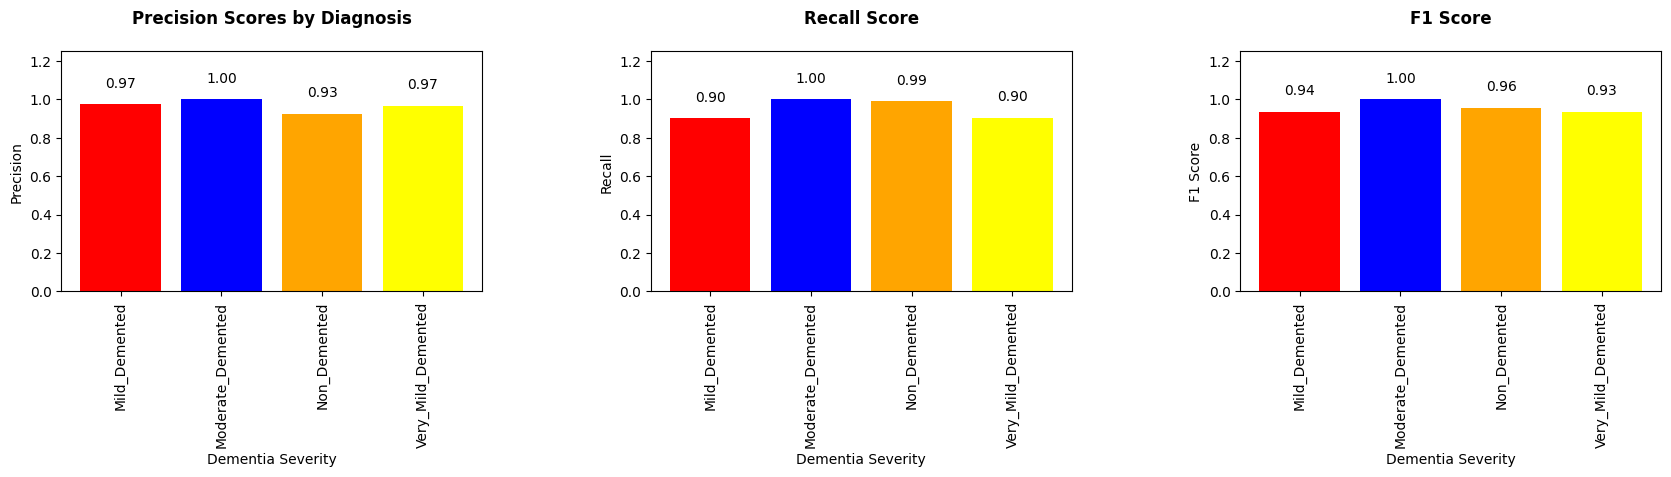

In [ ]:
clm_list=cls_report_df.T.index[:4].to_list()
prec_values=cls_report_df.T.iloc[0:4, 0].to_list()
rec_values=cls_report_df.T.iloc[0:4, 1].to_list()
f1_values=cls_report_df.T.iloc[0:4, 2].to_list()


f = plt.figure(figsize=(20,3))
f.tight_layout(pad=5)
ax = f.subplots(1, 3)

ax[0].set_title('Precision Scores by Diagnosis', pad=20, weight='bold')
bar_container = ax[0].bar(clm_list, prec_values, color=['red', 'blue', 'orange', 'yellow'])
ax[0].bar_label(bar_container, fmt='{:.2f}', padding=10)
ax[0].set_ylim(0,1.25)
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Dementia Severity')
ax[0].set_xticks(ticks=clm_list, labels=clm_list, rotation=90)

ax[1].set_title('Recall Score', pad=20, weight='bold')
bar_container = ax[1].bar(clm_list, rec_values, color=['red', 'blue', 'orange', 'yellow'])
ax[1].bar_label(bar_container, fmt='{:.2f}', padding=10)
ax[1].set_ylim(0,1.25)
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Dementia Severity')
ax[1].set_xticks(ticks=clm_list, labels=clm_list, rotation=90)

ax[2].set_title('F1 Score', pad=20, weight='bold')
bar_container = ax[2].bar(clm_list, f1_values, color=['red', 'blue', 'orange', 'yellow'])
ax[2].bar_label(bar_container, fmt='{:.2f}', padding=10)
ax[2].set_ylim(0,1.25)
ax[2].set_ylabel('F1 Score')
ax[2].set_xlabel('Dementia Severity')
ax[2].set_xticks(ticks=clm_list, labels=clm_list, rotation=90)

# Adjust spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

#### The model is highly accurate in its precision and recall scores of the 'Moderate Demented' class that was upsampled during training.  It seems to have helped in the model evaluation and inference stage on this class.  Given the seriousness and severity of the diagnosis, it is reassuring the model is calibrated well and does not produce any false positives or negatives.  The precision score for the 'Non Demented' and the recall score for the 'Mild Demented' need improvement.  Data augmentation techniques or obtaining more training data could possibly improve the results.